EDA of image files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class counts: {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


/tmp/ipython-input-3918054738.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="Set2")


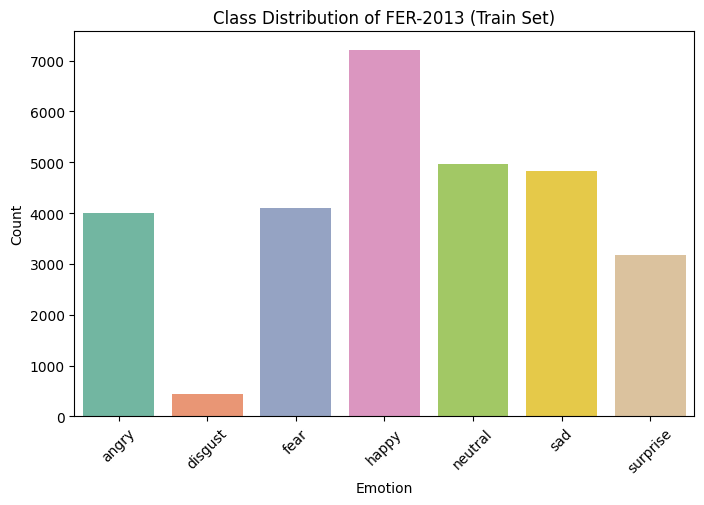

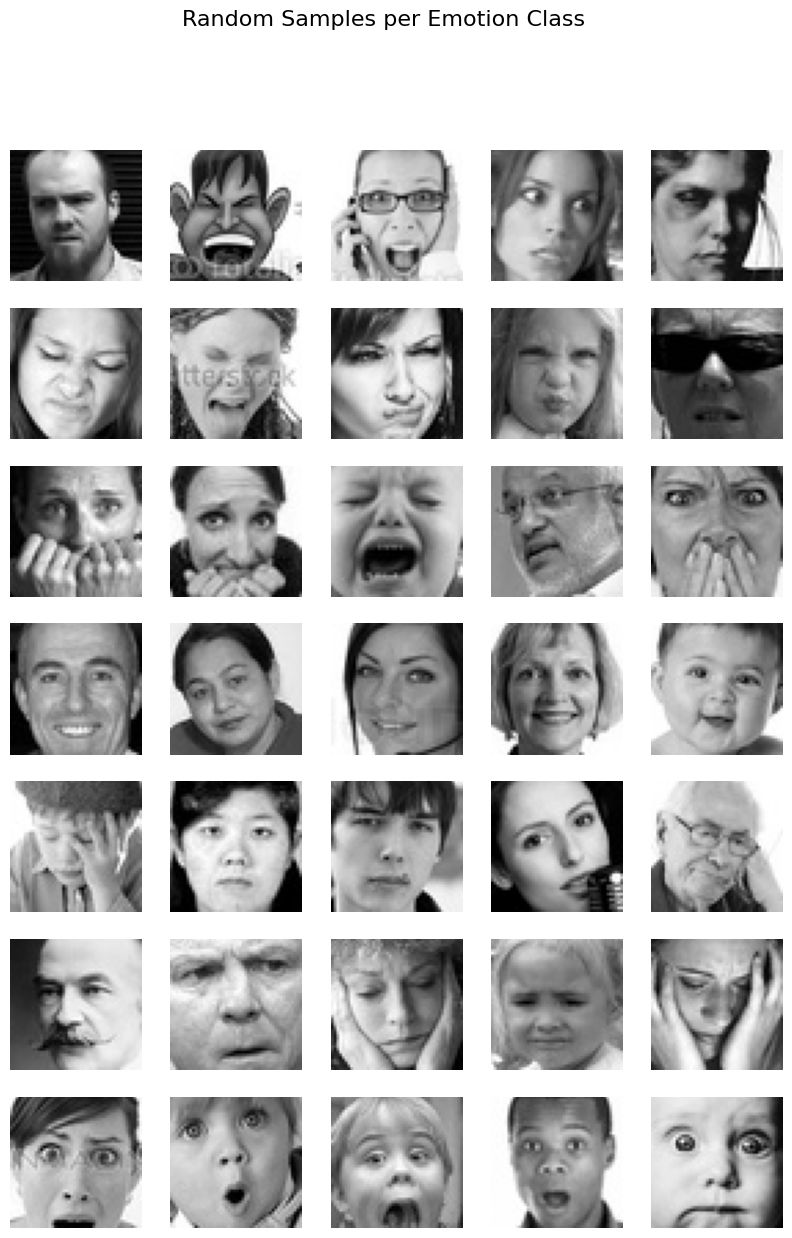

KeyboardInterrupt: 

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

# Root dataset directory (update path if needed)
data_dir = "drive/MyDrive/w281/data/fer_2013/train/"
#csv_train_file = 'drive/MyDrive/w281/fer_2013/data/df_train_1.csv'

# List of emotion classes = only directories (ignore hidden files like .DS_Store)
emotion_classes = sorted([
    d for d in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, d))
])
print("Emotion classes:", emotion_classes)

# Count images per class
class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(data_dir, cls))
        if os.path.isfile(os.path.join(data_dir, cls, f))
    ])
    for cls in emotion_classes
}
print("Class counts:", class_counts)

# ====== Class Distribution Plot ======
plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="Set2")
plt.title("Class Distribution of FER-2013 (Train Set)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# ====== Show Random Samples from Each Class ======
def plot_random_samples_per_class(samples=5):
    plt.figure(figsize=(samples*2, len(emotion_classes)*2))
    for row, cls in enumerate(emotion_classes):
        img_files = os.listdir(os.path.join(data_dir, cls))
        chosen = random.sample(img_files, samples)
        for col, fname in enumerate(chosen):
            img = Image.open(os.path.join(data_dir, cls, fname)).convert('L')
            plt.subplot(len(emotion_classes), samples, row*samples + col + 1)
            plt.imshow(img, cmap="gray")
            if col == 0:
                plt.ylabel(cls, rotation=90, size=12)
            plt.axis("off")
    plt.suptitle("Random Samples per Emotion Class", fontsize=16)
    plt.show()

plot_random_samples_per_class(samples=5)

# ====== Compute Average Face per Class ======
avg_faces = {}
for cls in emotion_classes:
    img_files = os.listdir(os.path.join(data_dir, cls))
    sum_img = None
    count = 0
    for fname in img_files:
        img = Image.open(os.path.join(data_dir, cls, fname)).convert('L')
        arr = np.array(img, dtype=np.float32)
        if sum_img is None:
            sum_img = np.zeros_like(arr)
        sum_img += arr
        count += 1
    avg_face = sum_img / count
    avg_faces[cls] = avg_face

# Plot average faces
plt.figure(figsize=(12, 6))
for i, (cls, avg_face) in enumerate(avg_faces.items()):
    plt.subplot(2, 4, i+1)
    plt.imshow(avg_face, cmap="gray")
    plt.title(cls)
    plt.axis("off")
plt.suptitle("Average Faces per Emotion", fontsize=16)
plt.tight_layout()
plt.show()

# ====== Image Intensity Stats ======
means, stds, labels = [], [], []
for cls in emotion_classes:
    img_files = os.listdir(os.path.join(data_dir, cls))
    for fname in random.sample(img_files, min(200, len(img_files))):  # sample up to 200 per class
        img = Image.open(os.path.join(data_dir, cls, fname)).convert('L')
        arr = np.array(img, dtype=np.float32)
        means.append(arr.mean())
        stds.append(arr.std())
        labels.append(cls)

stats = {"class": labels, "mean_intensity": means, "std_intensity": stds}
import pandas as pd
df_stats = pd.DataFrame(stats)

plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="mean_intensity", data=df_stats, palette="Set2")
plt.title("Distribution of Mean Pixel Intensity per Class")
plt.xticks(rotation=45)
plt.show()


HOG Implementation for Feature Extraction

HOG feature vector length: 900


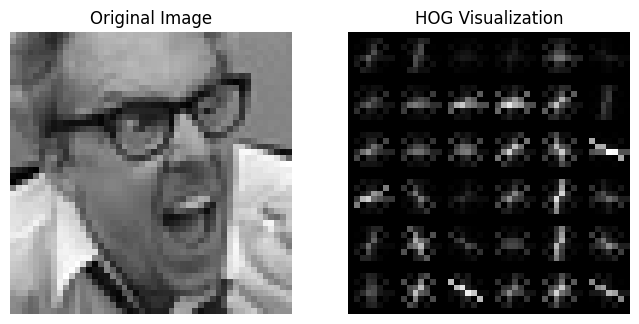

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure, io, color

# Example: load one FER-2013 grayscale image
# Replace this with your dataset path
image_path = data_dir+"angry/Training_3908.jpg"
image = io.imread(image_path, as_gray=True)

# Resize to 48x48 (FER-2013 standard)
from skimage.transform import resize
image_resized = resize(image, (48, 48))

# Extract HOG features
hog_features, hog_image = hog(
    image_resized,
    orientations=9,       # number of gradient orientations
    pixels_per_cell=(8, 8), # size of cell
    cells_per_block=(2, 2), # size of block
    block_norm="L2-Hys",
    visualize=True,
    feature_vector=True
)

print("HOG feature vector length:", len(hog_features))

# Show original + HOG visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis("off")
ax1.imshow(image_resized, cmap=plt.cm.gray)
ax1.set_title("Original Image")

# Rescale HOG for better contrast in visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis("off")
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title("HOG Visualization")

plt.show()


In [7]:
# ====== Compute mean HOG visualizations per class ======
from skimage.feature import hog
from skimage import exposure, io, color
from skimage.transform import resize
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# Parameters
samples_per_class = 200  # sample up to this many images per class to compute average HOG
image_size = (48, 48)
hog_params = dict(orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, feature_vector=True)

# Prepare containers
mean_hog_images = {}
mean_hog_vectors = {}
hog_lengths = {}

for cls in emotion_classes:
    cls_path = os.path.join(data_dir, cls)
    img_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    if len(img_files) == 0:
        continue
    chosen = random.sample(img_files, min(samples_per_class, len(img_files)))
    hog_imgs = []
    hog_vecs = []
    for fname in chosen:
        try:
            img = io.imread(os.path.join(cls_path, fname), as_gray=True)
        except Exception as e:
            # skip unreadable files
            continue
        img_resized = resize(img, image_size)
        vec, hog_image = hog(img_resized, **hog_params)
        # hog_image has the same shape as img_resized
        hog_imgs.append(hog_image)
        hog_vecs.append(vec)
    if len(hog_imgs) == 0:
        continue
    # mean HOG image (for visualization) and mean feature vector
    mean_hog = np.mean(np.stack(hog_imgs, axis=0), axis=0)
    mean_vec = np.mean(np.stack(hog_vecs, axis=0), axis=0)
    mean_hog_images[cls] = mean_hog
    mean_hog_vectors[cls] = mean_vec
    hog_lengths[cls] = np.linalg.norm(mean_vec)  # energy / magnitude

print('Computed mean HOG for classes:', list(mean_hog_images.keys()))


KeyboardInterrupt: 

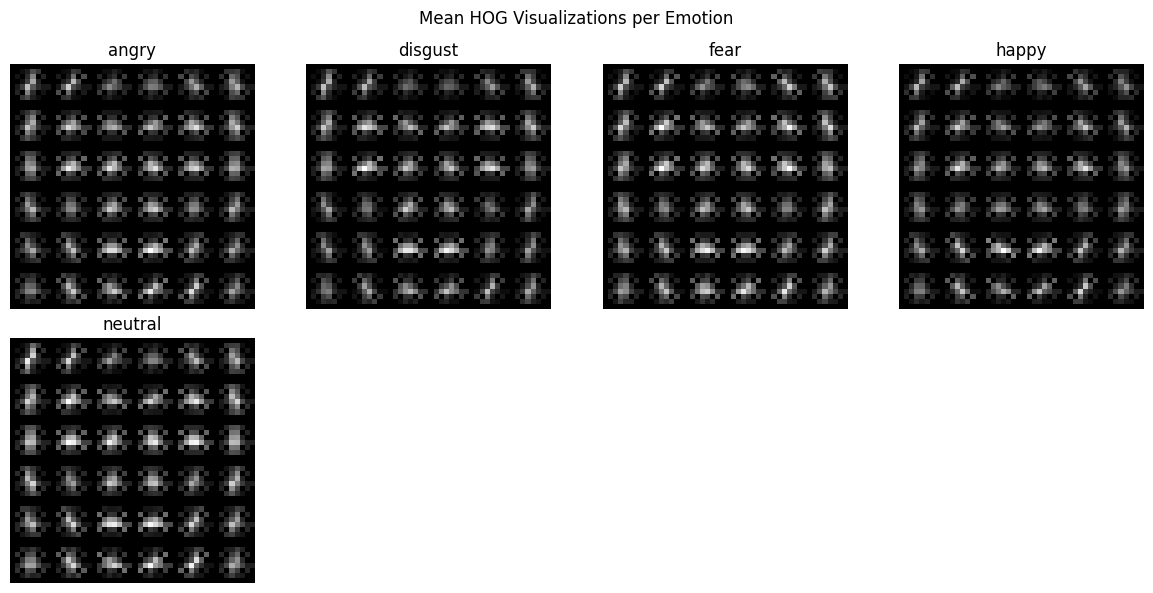

/tmp/ipython-input-4054989483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=energies, palette='Set2')


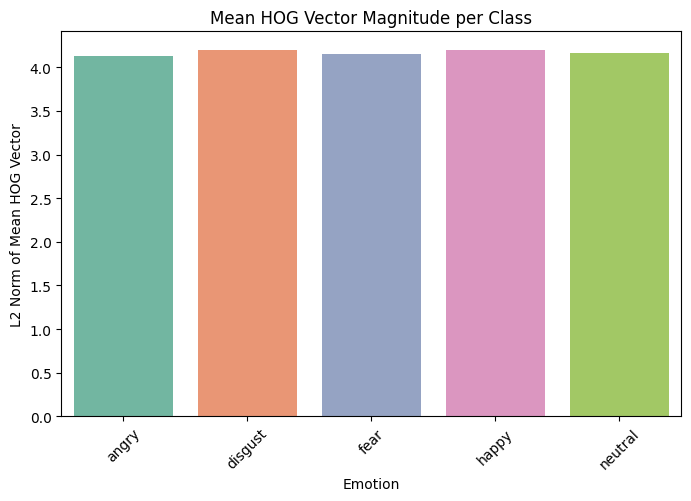

In [8]:
# ====== Plot mean HOG visualizations and barplot of mean HOG magnitude ======
import matplotlib.pyplot as plt
import seaborn as sns

# Plot mean HOG images in a grid
num = len(mean_hog_images)
cols = 4
rows = int(np.ceil(num / cols)) if num>0 else 0
plt.figure(figsize=(cols*3, rows*3))
i = 1
for cls, mean_hog in mean_hog_images.items():
    plt.subplot(rows, cols, i)
    # rescale for visibility
    img_disp = exposure.rescale_intensity(mean_hog, out_range=(0, 1))
    plt.imshow(img_disp, cmap='gray')
    plt.title(f'{cls}')
    plt.axis('off')
    i += 1
plt.suptitle('Mean HOG Visualizations per Emotion')
plt.tight_layout()
plt.show()

# Barplot of mean HOG magnitude (energy) per class
if len(hog_lengths) > 0:
    items = sorted(hog_lengths.items(), key=lambda x: x[0])
    classes = [k for k, v in items]
    energies = [v for k, v in items]
    plt.figure(figsize=(8,5))
    sns.barplot(x=classes, y=energies, palette='Set2')
    plt.title('Mean HOG Vector Magnitude per Class')
    plt.xlabel('Emotion')
    plt.ylabel('L2 Norm of Mean HOG Vector')
    plt.xticks(rotation=45)
    plt.show()
else:
    print('No HOG lengths to plot')


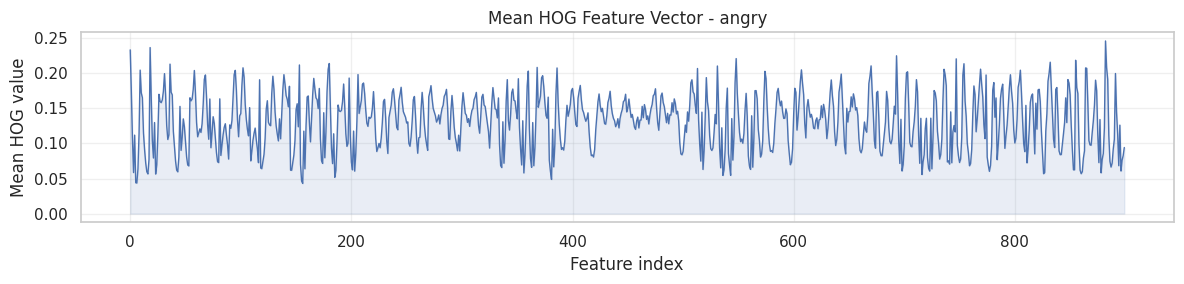

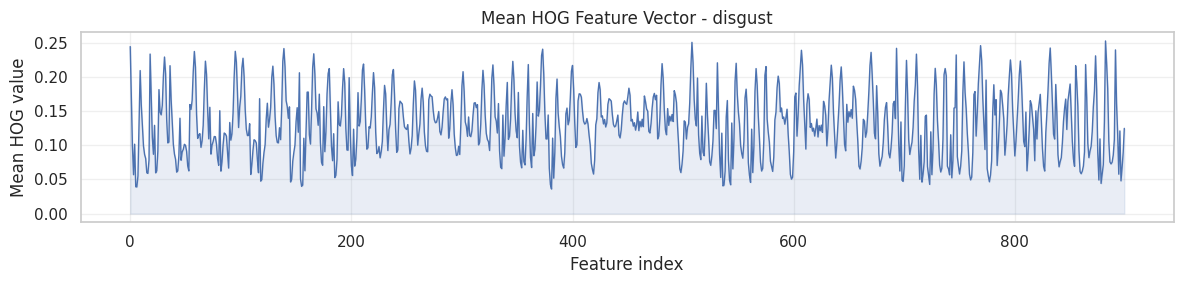

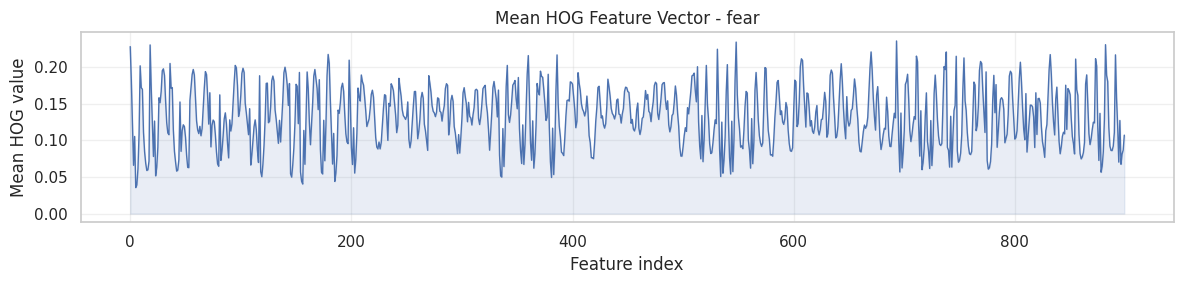

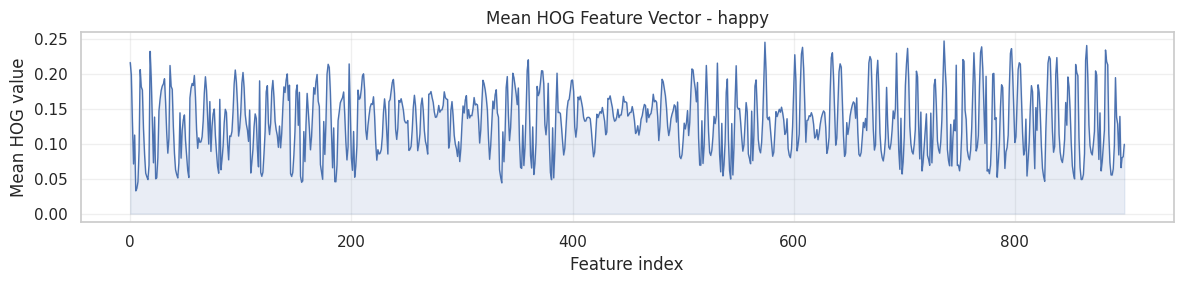

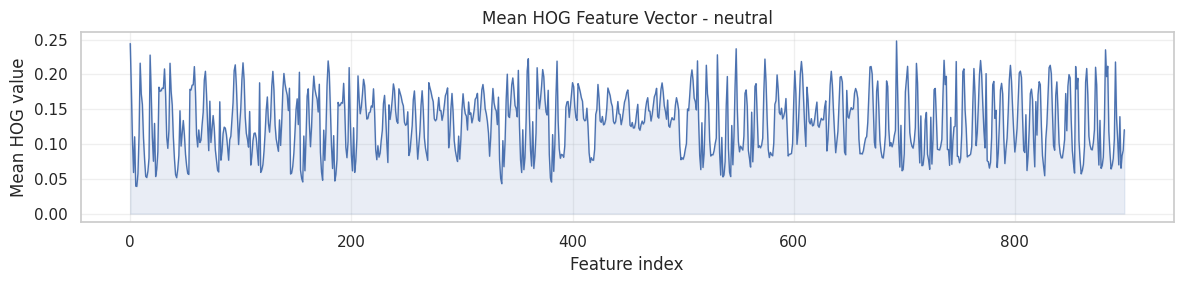

In [9]:
# ====== Plot per-class mean HOG vectors (one figure per emotion) ======
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='whitegrid')

# If you want to save each per-class plot set this to True
save_figures = False
out_dir = 'data/fer_2013/hog_mean_vectors'
if save_figures and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

if 'mean_hog_vectors' not in globals() or len(mean_hog_vectors) == 0:
    print('No mean HOG vectors found. Run the HOG-computation cell first.')
else:
    for cls in sorted(mean_hog_vectors.keys()):
        vec = np.asarray(mean_hog_vectors[cls]).ravel()
        plt.figure(figsize=(12,3))
        plt.plot(vec, lw=1, color='C0')
        plt.fill_between(np.arange(len(vec)), vec, alpha=0.12, color='C0')
        plt.title(f'Mean HOG Feature Vector - {cls}')
        plt.xlabel('Feature index')
        plt.ylabel('Mean HOG value')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_figures:
            fname = os.path.join(out_dir, f'mean_hog_vector_{cls}.png')
            plt.savefig(fname, dpi=150)
            print('Saved', fname)
        plt.show()


In [6]:
#!pip install --upgrade pip
#!pip install --upgrade setuptools wheel
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.6 MB/s  0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


Using device: cuda
Full train dataset size: 28709
Using a subset of train dataset with size: 5000
Val dataset size: 7178
Number of classes: 7


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3: train_loss=1.4852, train_acc=0.4380, val_loss=1.3362, val_acc=0.4925
Saved best model
Epoch 2/3: train_loss=1.0048, train_acc=0.6328, val_loss=1.2028, val_acc=0.5545
Saved best model
Epoch 3/3: train_loss=0.7582, train_acc=0.7432, val_loss=1.1759, val_acc=0.5722
Saved best model
Extracted features shape: (1000, 512)


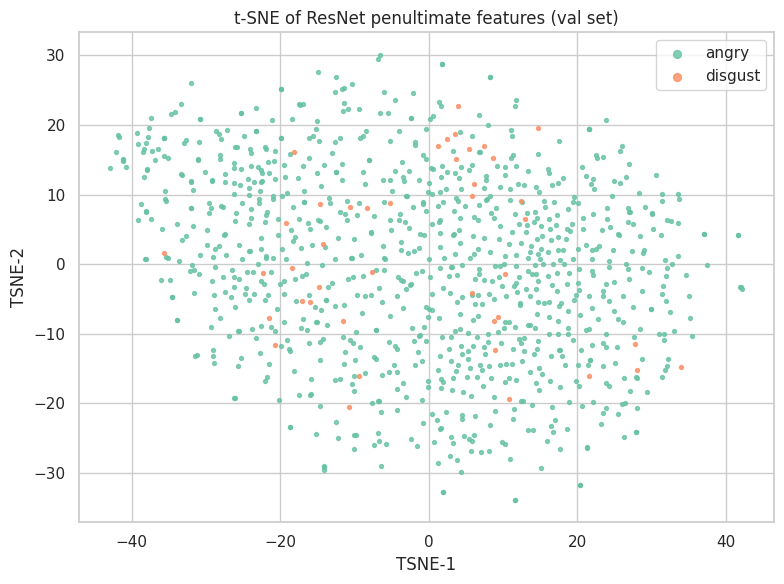

Done — ResNet fine-tune and feature extraction complete (quick run).


In [11]:
# ====== Pretrained ResNet18 fine-tune + feature extraction (penultimate layer) ======
# NOTE: This cell requires PyTorch and torchvision. Run on a machine with a GPU if available.
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Paths (adjust if your dataset is elsewhere)
train_dir = "drive/MyDrive/w281/data/fer_2013/train"
val_dir = "drive/MyDrive/w281/data/fer_2013/test" # optional validation/test folder

# Basic transforms: convert grayscale to 3-channel, resize to 224, normalize with ImageNet stats
input_size = 224
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
# Define a top-level converter to avoid pickling problems with lambdas in multiprocessing
def to_rgb(img):
    return img.convert('RGB')

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(to_rgb),  # use named function
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.Lambda(to_rgb),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Create datasets (ImageFolder expects subfolders per class)
train_ds_full = datasets.ImageFolder(train_dir, transform=train_transform)
print('Full train dataset size:', len(train_ds_full))

# Reduce the training dataset size for faster execution
train_sample_size = 5000 # Reduced sample size, adjust as needed
if len(train_ds_full) > train_sample_size:
    indices = random.sample(range(len(train_ds_full)), train_sample_size)
    train_ds = Subset(train_ds_full, indices)
    print(f'Using a subset of train dataset with size: {len(train_ds)}')
else:
    train_ds = train_ds_full
    print('Using the full train dataset as it is smaller than the sample size.')


# If you have a separate val_dir, use it; otherwise split train into train/val
if os.path.isdir(val_dir) and len(os.listdir(val_dir))>0:
    val_ds = datasets.ImageFolder(val_dir, transform=val_transform)
    print('Val dataset size:', len(val_ds))
else:
    # create a small val split (10%)
    val_size = int(0.1 * len(train_ds))
    train_size = len(train_ds) - val_size
    train_ds, val_ds = random_split(train_ds, [train_size, val_size])
    # When using random_split, the returned subsets don't carry transforms; wrap them
    # NOTE: This is a workaround; ideally, transforms should be applied before splitting or handled within a custom dataset
    # For ImageFolder subsets, the transform is retained, so no need to re-wrap here.
    print('Split train into', train_size, 'and', val_size)

# Increase batch size and num_workers for potential speedup if environment supports it
batch_size = 128 # Increased batch size
num_workers = 2 # Increased num_workers, adjust based on your environment capabilities
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# Use the classes from the train dataset
emotion_classes = train_ds_full.classes
num_classes = len(emotion_classes)
print('Number of classes:', num_classes)

# Build model: pretrained ResNet18 and replace final fc
model = models.resnet18(pretrained=True)
# Optionally freeze backbone layers to speed up training; here we'll fine-tune the whole network
# for param in model.parameters():
#     param.requires_grad = False
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Small training loop (2-3 epochs recommended for quick test) — increase for better results
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    return running_loss / total, correct / total

# Quick run: small number of epochs for testing
n_epochs = 3 # Reduced number of epochs
best_val_acc = 0.0
for epoch in range(1, n_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    print(f'Epoch {epoch}/{n_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18_fer2013.pth')
        print('Saved best model')

# ====== Feature extraction from penultimate layer ======
# We will extract the output of the global average pooling layer (before fc).
# Create a feature extractor by taking all layers except the final fc
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # outputs [B, C, 1, 1]
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# Collect features and labels from the validation set (or a sampled subset for speed)
max_samples = 1000  # limit for t-SNE; set None to use all
feats = []
labs = []
count = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = feature_extractor(imgs)  # shape B x C x 1 x 1
        outputs = outputs.view(outputs.size(0), -1).cpu().numpy()  # B x C
        feats.append(outputs)
        labs.append(labels.cpu().numpy())
        count += outputs.shape[0]
        if max_samples is not None and count >= max_samples:
            break
if len(feats) == 0:
    print('No features extracted; check val_loader and dataset.')
else:
    feats = np.vstack(feats)[:max_samples] if max_samples is not None else np.vstack(feats)
    labs = np.concatenate(labs)[:feats.shape[0]]
    print('Extracted features shape:', feats.shape)

    # t-SNE visualization
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
    emb = tsne.fit_transform(feats)
    plt.figure(figsize=(8,6))
    # Use the emotion_classes variable defined earlier
    palette = sns.color_palette('Set2', n_colors=len(emotion_classes))
    for i, cls in enumerate(sorted(emotion_classes)):
        mask = (labs == i)
        if mask.sum() == 0:
            continue
        plt.scatter(emb[mask,0], emb[mask,1], s=8, color=palette[i], label=cls, alpha=0.8)
    plt.legend(markerscale=2)
    plt.title('t-SNE of ResNet penultimate features (val set)')
    plt.xlabel('TSNE-1')
    plt.ylabel('TSNE-2')
    plt.tight_layout()
    plt.show()

print('Done — ResNet fine-tune and feature extraction complete (quick run).')